In [23]:
## Importing Libraries
from IPython.display import display, HTML, Image
from neo4j import GraphDatabase
from py2neo import Graph
import pandas as pd
import time
import os
import gc


#### HELPERS

In [24]:
## Credentials

uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
#graph = Graph("bolt://localhost:7687", auth=("neo4j", password))
#importer = ImportExample("bolt://localhost:7687", "neo4j", password)
graph = Graph(uri, auth=(user, password))

##### FUNCTION TO LOAD CSVs for NODES

In [25]:
##Import Nodes
class ImportExample:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def import_csv(self, files):
        total_time = 0
        with self.driver.session() as session:
            # Delete all nodes in database
            session.run('MATCH (n) DETACH DELETE n')
            print('Deleted all nodes in database')
            
            #Create Constraint
            for file, label in files:
                try:
                    session.run(f'CREATE CONSTRAINT {label.upper()} IF NOT EXISTS FOR (p:{label.upper()}) REQUIRE p.{label}id IS UNIQUE')
                    print(f'Created constraint for {label.upper()} node')
                except Exception as e:
                    print(f'Error creating constraint for {label.upper()} node')
                                    
            # Import data from CSV files
            for file, label in files:
                try:
                    start_time = time.time()
                    result = session.run(f'''
                    LOAD CSV WITH HEADERS FROM 'file:///{file}' AS row
                    WITH toInteger(row.{label}ID) AS {label}id, row
                    MERGE (o:{label.upper()} {{ {label}id: {label}id }})
                    SET o += row
                    RETURN count(o) AS count;
                    ''')
                    count = result.single()['count']
                    end_time = time.time()
                    total_time += end_time - start_time
                    print(f'Imported {count} nodes from {file} in {end_time - start_time:.2f} seconds')
                except Exception as e:
                    print(f'Error importing {file}: {str(e)}')
        print(f'Total time taken: {total_time:.2f} seconds')


##### FUNCTION TO LOAD CSVs for EDGE RELATIONSHIPS

In [26]:
class RelationshipImporter:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def import_relationships(self, files):
        total_time = 0
        with self.driver.session() as session:
            for file, rel_type, start_node_label, end_node_label, start_node_id, end_node_id in files:
                try:
                    start_time = time.time()
                    result = session.run(f'''
                    LOAD CSV WITH HEADERS FROM 'file:///{file}' AS row
                    WITH toInteger(row.{start_node_id}) AS {start_node_id}, toInteger(row.{end_node_id}) AS {end_node_id}
                    MATCH (s:{start_node_label} {{ {start_node_id}: {start_node_id} }})
                    MATCH (e:{end_node_label} {{ {end_node_id}: {end_node_id} }})
                    MERGE (s)-[rel:{rel_type.upper()}]->(e)
                    RETURN count(rel);
                    ''')
                    count = result.single()[0]
                    end_time = time.time()
                    total_time += end_time - start_time
                    print(f'Imported {rel_type} edges from {file} in {end_time - start_time:.2f} seconds')
                    #print(f'Done loading {file}, created {count} relationships')
                except Exception as e:
                    print(f'Error loading {file}: {str(e)}')


## LAB WORK

#### A.1 Modeling

##### Initial Graph Model

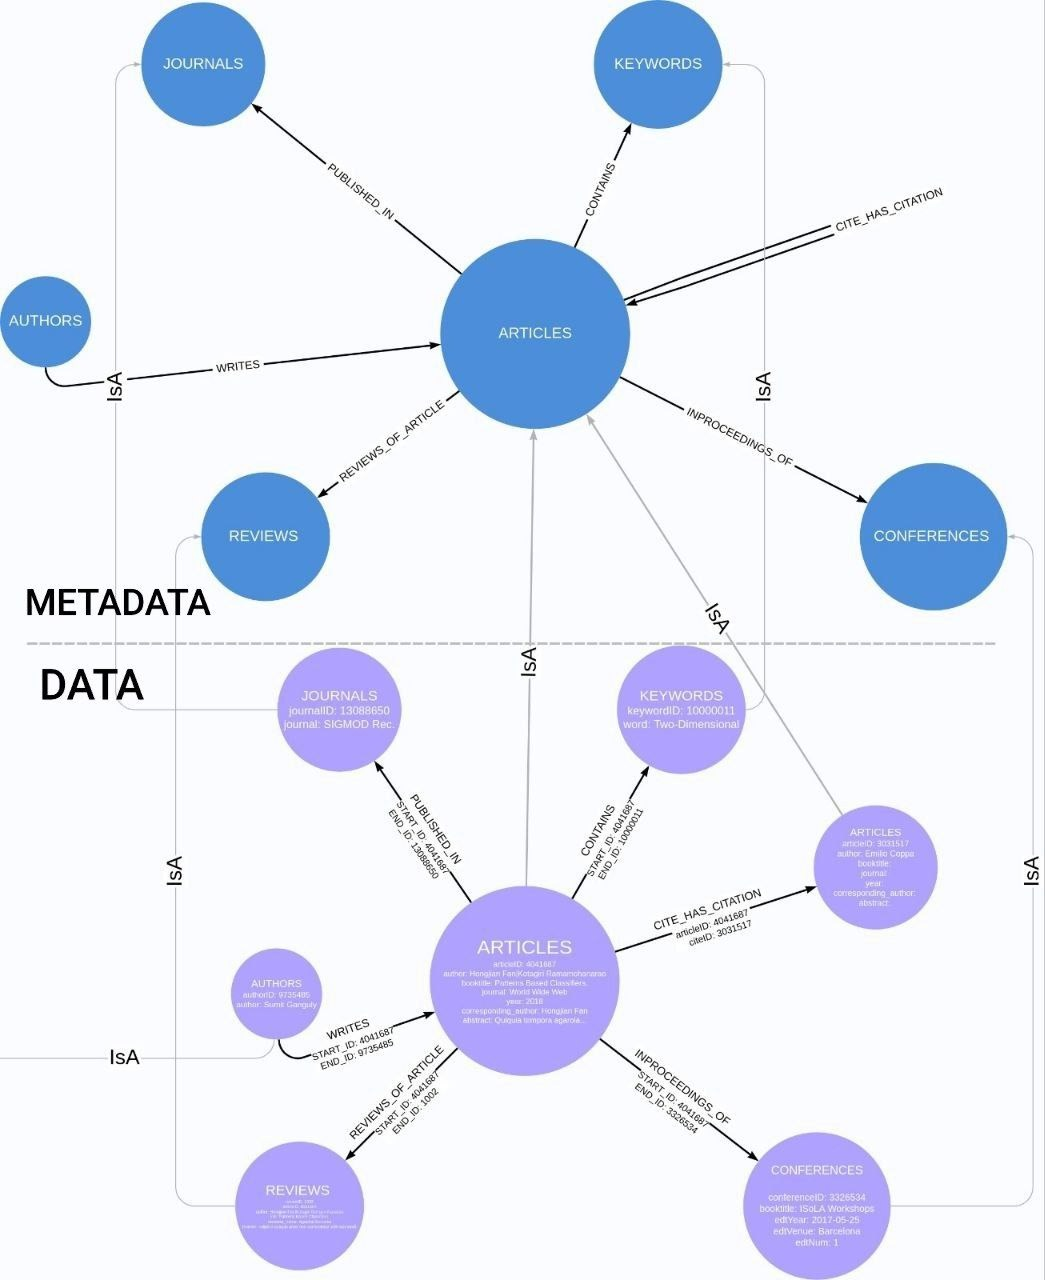

In [64]:
# Image showing Initial graph
Image('Mains/Initiald.jpg',  width=500, height=500)

#### A2 Loading

In [28]:
## Files for Nodes list
node_files = [("authors.csv", "author"), ("articles.csv", "article"), ("journals.csv", "journal"), ("keywords.csv", "keyword"), 
              ("school.csv", "school"), ("reviews.csv", "review"), ("conferences.csv", "conference") ]

In [29]:
## Call Node importer method
importer = ImportExample(uri, user, password)
importer.import_csv(node_files)
importer.close()

Deleted all nodes in database
Created constraint for AUTHOR node
Created constraint for ARTICLE node
Created constraint for JOURNAL node
Created constraint for KEYWORD node
Created constraint for SCHOOL node
Created constraint for REVIEW node
Created constraint for CONFERENCE node
Imported 1000 nodes from authors.csv in 0.14 seconds
Imported 10000 nodes from articles.csv in 1.92 seconds
Imported 8 nodes from journals.csv in 0.12 seconds
Imported 117 nodes from keywords.csv in 0.07 seconds
Imported 2352 nodes from school.csv in 0.22 seconds
Imported 30000 nodes from reviews.csv in 2.83 seconds
Imported 8 nodes from conferences.csv in 0.07 seconds
Total time taken: 5.37 seconds


In [30]:
# Clear garbage
gc.collect()

79

In [31]:
## Files for relationship list
relationship_files = [('authors_writes_articles.csv', 'WRITES', 'AUTHOR', 'ARTICLE', 'authorid', 'articleid'),
                      ('articles_in_conferences.csv', 'INPROCEEDINGS_OF', 'ARTICLE', 'CONFERENCE', 'articleid', 'conferenceid'),
                      ('articles_in_journal.csv', 'PUBLISHED_IN', 'ARTICLE', 'JOURNAL', 'articleid', 'journalid'),
                      ('reviews_in_articles.csv', 'REVIEWS', 'ARTICLE', 'REVIEW', 'articleid', 'reviewid'),
                      ('article_keywords.csv', 'CONTAINS', 'ARTICLE', 'KEYWORD', 'articleid', 'keywordid'),
                      ('author_affiliated_school.csv', 'AFFILIATED_WITH', 'AUTHOR', 'SCHOOL', 'authorid', 'schoolid')]

In [32]:
# Call relationship method
relationship_importer = RelationshipImporter(uri, user, password)
relationship_importer.import_relationships(relationship_files)
relationship_importer.close()


Imported WRITES edges from authors_writes_articles.csv in 4.57 seconds
Imported INPROCEEDINGS_OF edges from articles_in_conferences.csv in 0.53 seconds
Imported PUBLISHED_IN edges from articles_in_journal.csv in 0.28 seconds
Imported REVIEWS edges from reviews_in_articles.csv in 2.07 seconds
Imported CONTAINS edges from article_keywords.csv in 2.08 seconds
Imported AFFILIATED_WITH edges from author_affiliated_school.csv in 7.55 seconds


In [33]:
## Loading Citation specially because it has many to many relationship with itself
Citation = """
LOAD CSV WITH HEADERS FROM 'file:///cite_has_citation.csv' AS row
WITH toInteger(row.articleid) AS articleid, toInteger(row.citaid) AS citaid
MATCH (p:ARTICLE {articleid: articleid})
MATCH (o:ARTICLE {articleid: citaid})
MERGE (p)-[rel:CITE_HAS_CITATION]->(o)
RETURN count(rel);"""

graph.run(Citation)

count(rel)
13397


In [34]:
# Clear garbage
gc.collect()

79

#### A.3 Evolving the graph

##### Evolved Graph Model

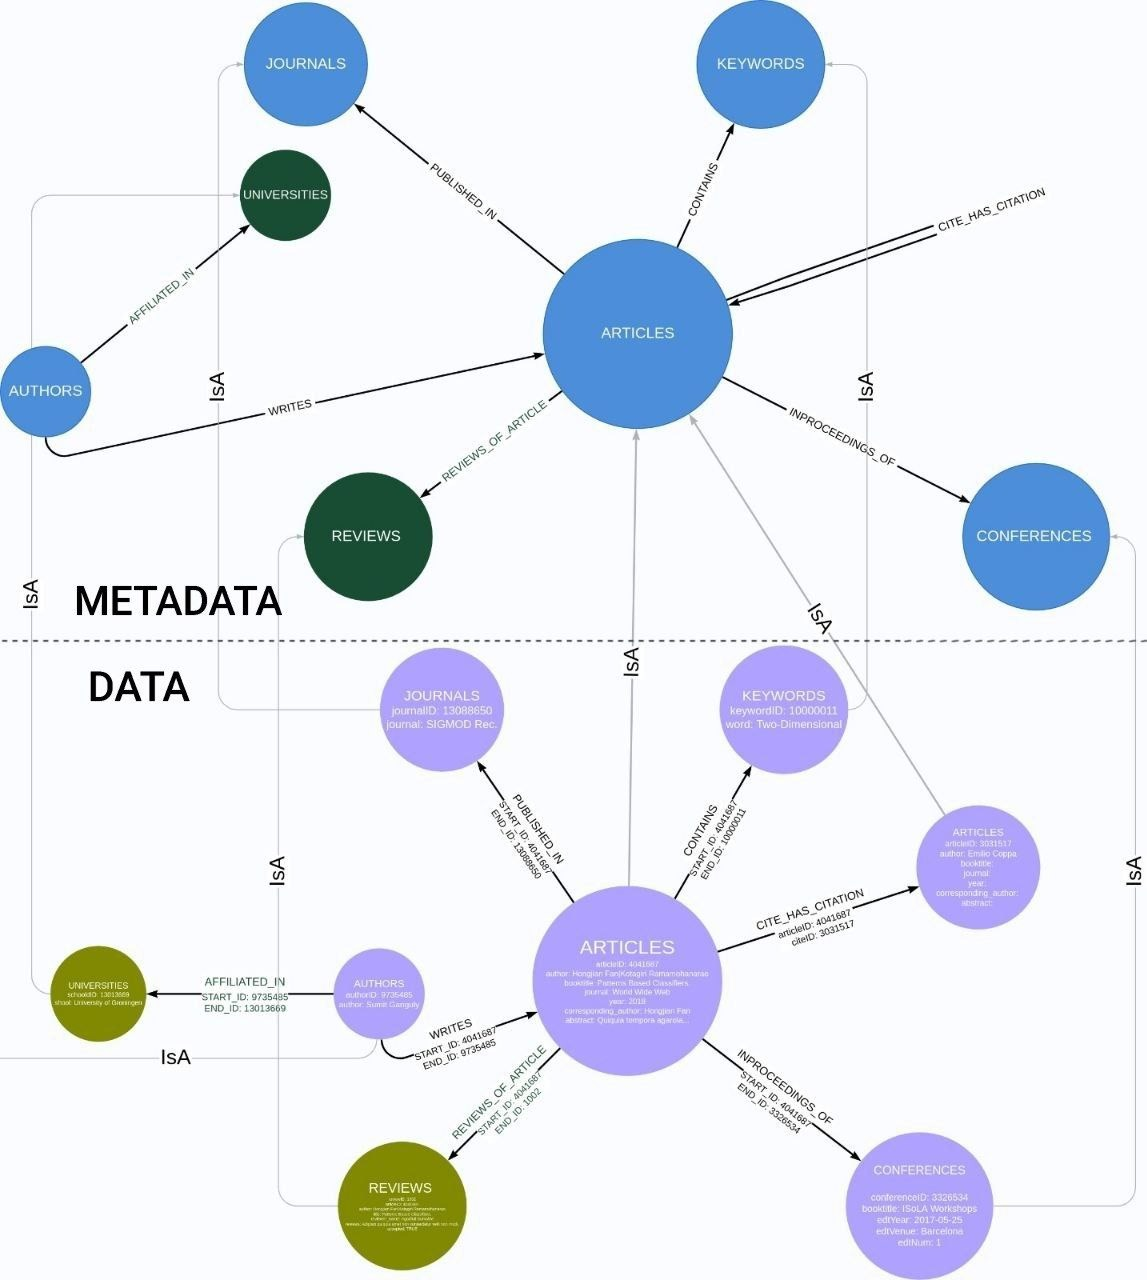

In [65]:
# Image showing Evolved graph
Image('Mains/evolvedd.jpg',  width=600, height=600)

#### B. Querying

##### 1. Find the top 3 most cited papers of each conference.

In [36]:
most_cited_papers  = """
MATCH (ar:ARTICLE)<-[r:CITE_HAS_CITATION]-(a:ARTICLE)-[:INPROCEEDINGS_OF]->(c:CONFERENCE)
WITH c, a, count(r) AS citations
ORDER BY c.`ConfName:string`, citations DESC
WITH c, collect({article: a, citations: citations}) AS articles
RETURN c.`ConfName:string` AS conference, articles[0].article.`title:string` AS top_cited_1, articles[0].citations AS citations_1, articles[1].article.`title:string` AS top_cited_2, articles[1].citations AS citations_2, articles[2].article.`title:string` AS top_cited_3, articles[2].citations AS citations_3
ORDER BY c.`ConfName:string`;"""

graph.run(most_cited_papers)

conference,top_cited_1,citations_1,top_cited_2,citations_2,top_cited_3,citations_3
European Conference on Artificial Intelligence (ECAI),Tracking control with prescribed transient behaviour for systems of known relative degree.,10,A combinatorial 2.375-approximation algorithm for the facility location problem with submodular penalties.,9,A varying terminal time mean-variance model.,9
European Conference on Computer-Supported Cooperative Work (ECSCW),The Complexity of Logical Theories.,11,Improved Outdoor Localization Based on Weighted Kullback-Leibler Divergence for Measurements Diagnosis.,9,Stability of linear second-order time-varying differential equations via contractive polygons.,9
European Conference on Human-Computer Interaction (ECHI),An Enhanced Histogram of Oriented Gradients for Pedestrian Detection.,9,Mixing logics and rewards for the component-oriented specification of performance measures.,8,Profit Maximization problem with Coupons in social networks.,8


##### 2. For each conference find its community: i.e., those authors that have published papers on that conference in, at least, 4 different editions.

In [37]:
conf_comm = """
MATCH (a:AUTHOR)-[:WRITES]->(p:ARTICLE)-[:INPROCEEDINGS_OF]->(c:CONFERENCE)
WITH a, c, COUNT(DISTINCT p) AS papers, COLLECT(DISTINCT p.`year:int`) AS years
WHERE papers >= 4 AND SIZE(years) >= 4
WITH c, COLLECT(DISTINCT a.`author:string`) AS community
RETURN c.`ConfName:string`, community;"""

graph.run(conf_comm)

c.`ConfName:string`,community
International Conference on Data Mining (ICDM),"['Rogier Woltjer', 'Per Carlsson', 'Hannes Holm', 'PerOlof Bengtsson', 'Johan Eklund', 'Masatsugu Hangyo', 'Wiradee Imrattanatrai', 'Kim J. L. Nevelsteen', 'Floris Erich', 'Hisao Ogata', 'Syafril Bandara', 'Ehab Morsy', 'Kanae Akaiwa', 'Raghvendra Jain', 'Hironori Kiya', 'Simin Cai', 'Hamid Farhady', 'Ruijian An', 'Jan Erik Mostr\u00f6m', 'J. Rafid Siddiqui', 'Helena Lindgren', 'Loove Broms', 'Takuya Tsutsumi', 'Georg Hodosi', 'Frank Spie\u00df', 'Mikael Wiberg', 'Meng-Yu Kuo', 'Bob Melander', 'Jun-Li Lu', 'Hung Nghiep Tran', 'Tim Overkamp', 'Andrii Dmytryshyn', 'Karl Ljungkvist', 'Masaki Waga', 'Ahmed Ishtiaq', 'Hannes Ebner', 'Yiming Wu', 'Sameh El-Ansary', 'Thi Ngoc Dung Tieu', 'H\u00e5kan Jonsson', 'Tobias Olsson', 'Karin Danielsson \u00d6berg', 'Andrzej Pronobis', 'John W. Richardson', 'John Brumley', 'Yu Nakahata', 'Ranil Peiris', 'Aseel Berglund', 'Romain Fontugne', 'Mark A. Friedman', 'Anders Berglund', 'Tove Helldin', 'Marc A. Kastner 0001', 'Magnus Ingmarsson', 'Sanjay Ghemawat', 'Sergey Tarasenko', 'Jonathan Crusoe', 'Shahzad Saleem', 'Denis Kleyko', 'Abdelbaki Bouguerra', 'Huan Liu', 'Somchai Chatvichienchai', 'Erik Johansson', 'Wito Engelke', 'Malin Sandstr\u00f6m', 'Mo Shen', 'Muhammad Usman 0002', 'Yoshiyuki Shoji', 'Hoang-Quoc Nguyen-Son', 'Robert A. Granat', 'Fredrik Edin', 'Si-Mohamed Lamraoui', 'Kosetsu Tsukuda', 'Dieter Altenburger', 'Loic Merckel', 'Ryousuke Matsumoto', 'Thomas Weish\u00e4upl', 'Asmus Pandikow', 'Maike Paetzel-Pr\u00fcsmann', 'Namgi Han', 'Jens-Olof Lindh', 'Sergii Voronov', 'Gustav Nordh', 'Charles N. Tarimo', 'Marcel Cavalcanti de Castro', 'Kensuke Tanioka', 'Masato Shinjo', 'Gianantonio Bortolin', 'Hoc Phan', 'Islam A. K. M. Mahfuzul', 'Shotaro Kamiya', 'Yu Terada']"
International Joint Conference on Artificial Intelligence (IJCAI),"['Kazuki Maeda', 'Shuhei Kato', 'Ott Velsberg', 'Hosea Ayaba Ofe', 'Fredrik Paulsson', 'Masoumeh Mansouri', 'Martin Blom', 'Sichao Song 0001', 'Samar El Helou', 'Sara Johansson 0001', 'J. Rafid Siddiqui', 'Patrik \u00d6sterberg', 'Ryousuke Matsumoto', 'Rahul Hiran', 'Montathar Faraon', 'Fayiq Alghamdi', 'Song Bian 0001', 'Miroslaw Staron', 'Martin Svensson', 'Hadi Banaee', 'Johannes Hjorth', 'Lena Kallin Westin', 'Ece Calikus', 'Lawrence Henesey', 'Toshiyuki Hagiya', 'Marie-Therese Christiansson', 'Raihan Ul Islam', 'Song Tong', 'Azza Abdel Rahman Taha Abdel Halim', 'Martin Kronbichler 0002', 'Yuki Goto', 'Ruiting Ouyang', 'Jean Xiang-Qun Yu', 'Mikael Jakobsson', 'John W. Richardson', 'David Cournapeau', 'Theresia Olsson Neve', 'Florian Westphal', 'Liu Yu', 'Jiro Kikkawa', 'Damien Le Moal', 'Martin Rehn', 'Hideaki Ohashi', 'Tomoaki Kawada', 'Robert Krug 0002', 'Anders Frank', 'Yuta Kozaki', 'Xavier Olive', 'Daniel Nyl\u00e9n', 'Risa Uechi', 'Qiang Zhi', 'Matti Itkonen', 'Tomoyuki Mukasa', 'David Sundgren', 'Lars Larsson 0001', 'Nararat Ruangchaijatupon', 'Matthias Demoucron', 'Mondheera Pituxcoosuvarn', 'Hironori Kiya', 'Martin Kero', 'Yumi Shikauchi', 'Daisuke Kotani', 'Tatu Yl\u00f6nen', 'Anna Jonsson', 'Magnus Eriksson', 'Malcolm Mielle', 'Yang Qin 0002', 'Muhammad Usman 0002', 'Yasutoshi Ida', 'Chenxi Tu', 'Masoom Alam', 'Tong Gan', 'Koyo Nitta', 'Daichi Kitamura', 'Per Wikberg', 'Anders Lundstr\u00f6m', 'Aleksandar Shurbevski', 'Lars Petersson', 'Md. Nurul Huda', 'Bernadette Emsenhuber', 'Kalle Jegers', 'Giampiero Salvi', 'Rikta Sen', 'Fredrik Espinoza', 'Rikard Laxhammar']"
European Conference on Human-Computer Interaction (ECHI),"['Zhi Liu 0002', 'Hoang-Quoc Nguyen-Son', 'Ryosuke Onose', 'Yijun Duan', 'George Ungureanu', 'Takahiro Yamakoshi', 'Daiki Tanaka', 'Daniel Flemstr\u00f6m', 'Magnus Rosell', 'Jaafar AlMutawa', 'Sebastian Barney', 'Thomas Larsson', 'P\u00e4r J. \u00c5gerfalk', 'Erik Perjons', 'Hiroaki Kingetsu', 'Fabian Segelstr\u00f6m', 'Akira Maezawa', 'Nasir Mehmood Minhas', 'Chenxi Tu', 'Ra\u00fal Ernesto Men\u00e9ndez-Mora', 'Viktor Iv\u00e1dy', 'Peng Zhang', 'Ma

##### 3. Find the impact factors of the journals in your graph

In [38]:
year_to_int = """MATCH (a:ARTICLE)
SET a.`year:int` = toInteger(a.`year:int`);"""

graph.run(year_to_int)

(No data)

In [39]:
impact_factors = """MATCH (j:JOURNAL)<-[:PUBLISHED_IN]-(a:ARTICLE)
WHERE a.`year:int` >= 2017 AND a.`year:int`  <= 2018
WITH j, COLLECT(DISTINCT a) AS ARTICLE
MATCH (c:ARTICLE)<-[:CITE_HAS_CITATION]-(a)
WHERE c.`year:int` <= 2019
WITH j, COUNT(DISTINCT c) AS citations, ARTICLE
RETURN j.`journal:string` AS Journal, toFloat(citations)/toFloat(SIZE(ARTICLE)) AS TwoYearImpactFactor
ORDER BY TwoYearImpactFactor DESC;"""

graph.run(impact_factors)

Journal,TwoYearImpactFactor
Inf. Technol. Dev.,35.82887700534759
Theor. Comput. Sci.,35.26315789473684
Sci. Comput. Program.,34.35897435897436


##### 4. Find the h-indexes of the authors in your graph

In [40]:
h_indexes = """MATCH (a:AUTHOR)-[:WRITES]->(p:ARTICLE)
WITH a, COLLECT(DISTINCT p.`year:int`) AS years, COUNT(DISTINCT p) AS num_papers
UNWIND RANGE(1, num_papers) AS i
WITH a, years, REDUCE(s = 0, j IN COLLECT(i) | s + CASE WHEN j <= SIZE(years) AND years[j-1] <= 2022 - j + 1 THEN 1 ELSE 0 END) AS h_index
RETURN a.authorID AS Author_ID, a.`author:string` AS Author, h_index
ORDER BY h_index DESC;"""

graph.run(h_indexes)

Author_ID,Author,h_index
9735494,Tomoya Mori,5
9735599,Tatsuhisa Yamaguchi,5
9735690,Natthawut Kertkeidkachorn,5


#### C. Recommender

##### 1. Find the research communities related by keywords

In [41]:
## Step 1.1 - Create database community node 
community = """MERGE (c:community {name:'db'})
ON CREATE SET c.created_at = timestamp()
RETURN c;"""

graph.run(community)

c
"(_3500:community {created_at: 1678925201438, name: 'db'})"


In [42]:
## Step 1.2 - Define which keywords related to the database community

comm_kw = """MATCH (c:community {name:'db'})
MATCH (kw:KEYWORD)
WHERE kw.`word:string` in ['data management', 'indexing', 'data modeling', 'big data', 'data processing', 'data storage' , 'data querying']
MERGE (kw)-[:RELATED_TO]->(c)
RETURN c;"""

graph.run(comm_kw)

c
"(_3500:community {created_at: 1678925201438, name: 'db'})"
"(_3500:community {created_at: 1678925201438, name: 'db'})"
"(_3500:community {created_at: 1678925201438, name: 'db'})"


##### 2. Find the conferences and journals related to the database community

In [43]:
## Step 2 - Assumption: If 90% of the papers published in a conference/journal contain one of the keywords 

related_c_j = """
//Journal
MATCH (a:ARTICLE)-[:PUBLISHED_IN]->(j1)
WITH j1, j1.`journal:string` AS Name, count(*) AS  num_papers
WHERE num_papers > 0
MATCH (j1)<-[:PUBLISHED_IN]-(a:ARTICLE)-[:CONTAINS]->(kw:KEYWORD)-[:RELATED_TO]->(com:community {name:'db'})
WITH j1,com,Name,  num_papers, count(distinct a.`title:string`) AS  num_papers_db, a.sup as type
WITH j1, com, Name, num_papers, num_papers_db, (1.0*num_papers_db/num_papers) AS db_percentage, type
WHERE db_percentage >= 0.9
MERGE (j1)-[:RELATED_TO]->(com)
RETURN Name, type,  num_papers,num_papers_db, db_percentage

UNION

//Conference
MATCH (a:ARTICLE)-[:INPROCEEDINGS_OF]->(c1)
WITH c1, c1.`ConfName:string` AS Name, count(*) AS  num_papers
WHERE num_papers > 0
MATCH (c1)<-[:INPROCEEDINGS_OF]-(a:ARTICLE)-[:CONTAINS]->(kw:KEYWORD)-[:RELATED_TO]->(com:community {name:'db'})
WITH c1,com,Name,  num_papers, count(distinct a.`title:string`) AS  num_papers_db, a.sup AS type
WITH c1, com, Name, num_papers, num_papers_db, (1.0*num_papers_db/num_papers) AS db_percentage, type
WHERE db_percentage >= 0.9
MERGE (c1)-[:RELATED_TO]->(com)
RETURN Name,type,  num_papers,num_papers_db, db_percentage;"""

graph.run(related_c_j)

Name,type,num_papers,num_papers_db,db_percentage
Found. Comput. Math.,J,450,446,0.9911111111111112
IEEE Embed. Syst. Lett.,J,439,436,0.9931662870159453
J. Assoc. Inf. Syst.,J,423,422,0.9976359338061466


##### 3. Identify the top papers of these conferences/journals.

In [45]:
## Step 3.1 Create a PageRank method using gds library

PageRank = """CALL gds.graph.project(
  'myPageRank',
  'ARTICLE',
  'CITE_HAS_CITATION'
);"""

graph.run(PageRank)

nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
"{ARTICLE: {label: 'ARTICLE', properties: {}}}","{CITE_HAS_CITATION: {orientation: 'NATURAL', indexInverse: false, aggregation: 'DEFAULT', type: 'CITE_HAS_CITATION', properties: {}}}",myPageRank,10000,13397,87


In [47]:
## Step 3.2 Call a PageRank Algorithm method using gds stream
## Identify top 100

top_100 = """CALL gds.pageRank.stream('myPageRank')
YIELD nodeId, score
WITH gds.util.asNode(nodeId).articleid AS ID, gds.util.asNode(nodeId).`title:string` AS title, score
ORDER BY score DESC, title ASC
MATCH (com:community {name:'db'})
WITH ID, com, score, title
MERGE (:ID)-[:RELATED_TO]->(com)
RETURN ID, title, score
limit 100;"""

graph.run(top_100)

ID,title,score
6620607,On permuted super-secondary structures of transmembrane β-barrel proteins.,0.405
6612420,Structure Inference for Linked Data Sources Using Clustering.,0.405
6612436,An Adaptive Similarity Search in Massive Datasets.,0.34125000000000005


##### 4. Identify the gurus

In [49]:
gurus = """
MATCH (au:AUTHOR)-[:WRITES]->(b:ARTICLE)-[:INPROCEEDINGS_OF]-(:CONFERENCE)-[:RELATED_TO]->(com:community {name:'db'})
WITH au, COUNT(*) AS  num
WITH au, au.`author:string` AS author_name, num AS num_influential_papers, CASE WHEN num >=2 THEN 'guru' ELSE 'reviewer' END AS reviewer_type
MERGE (au)-[:RELATED_TO {type:reviewer_type}]->(com)
RETURN author_name, num_influential_papers, reviewer_type
ORDER BY num_influential_papers DESC;"""

graph.run(gurus)

author_name,num_influential_papers,reviewer_type
Hannes Holm,32,guru
Raihan Ul Islam,31,guru
Romain Fontugne,31,guru


#### D. Graph algorithms

##### 1. Closeness Centrality - Centrality Algorithms

###### Closeness centrality is a way of detecting nodes that are able to spread information very efficiently through a graph. In this case we want to articles in the community that are highly connected.


In [51]:
## Call previous algorithm method using gds stream

closeness = """CALL gds.beta.closeness.stream('myPageRank')
YIELD nodeId, score
WITH gds.util.asNode(nodeId).articleid AS ID, gds.util.asNode(nodeId).`title:string` AS title, score
ORDER BY score DESC, title ASC
MATCH (com:community {name:'db'})
WITH ID, com, score, title
MERGE (:ID)-[:RELATED_TO]->(com)
RETURN ID, title, score
limit 100;"""

graph.run(closeness)

ID,title,score
6619440,"""A la Burstall"" Intermittent Assertions Induction Principles for Proving Inevitable Ability Properties of Programs.",1.0
6620955,"""Almost stable"" matchings in the Roommates problem with bounded preference lists.",1.0
6611966,"""Postéditorial"": Les Universités d'Aix-Marseille sur les routes de la soie.",1.0


##### 2. Louvain - Community Detection Algorithms

###### The Louvain method is an algorithm to detect communities in large networks. Here we create a community of articles based on years.

In [54]:
## Create a Community Algorithm method using gds library
# This algo creates an undirected community based on ARTICLEs, keywords and the year

myCommunity = """CALL gds.graph.project(
    'myCommunity',
    'ARTICLE',
    {
        CONTAINS:{
            orientation: 'UNDIRECTED'
        }
    },
    {
        nodeProperties: 'year:int'
        //relationshipProperties: ''
    }
);"""

graph.run(myCommunity)

nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
"{ARTICLE: {label: 'ARTICLE', properties: {`year:int`: {defaultValue: null, property: 'year:int'}}}}","{CONTAINS: {orientation: 'UNDIRECTED', indexInverse: false, aggregation: 'DEFAULT', type: 'CONTAINS', properties: {}}}",myCommunity,10000,0,156


In [58]:
## Call a previously made algorithm method using gds stream

louvain = """CALL gds.louvain.stream('myCommunity',{ includeIntermediateCommunities: true })
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId).`title:string` AS title, communityId, intermediateCommunityIds, gds.util.asNode(nodeId).sup AS type, gds.util.asNode(nodeId).`year:int` AS year
WHERE type = 'C' and year = 2019
RETURN communityId, title;"""

graph.run(louvain)

communityId,title
21,Simulating a trust-based service recommender system for decentralised user modelling environment.
24,EDARD: efficient data access based on rumour dissemination in wireless sensor networks.
26,Computationally perfect compartmented secret sharing schemes based on MDS codes.


##### 3. Triangle - Community Detection Algorithms

##### Triangle Count algorithm can be used to identify the number of triangles or three-node 

In [60]:
# Call a previously made algorithm method using gds stream
triangle = """CALL gds.triangleCount.stream('myCommunity')
YIELD nodeId, triangleCount
RETURN gds.util.asNode(nodeId).articleid AS name
ORDER BY triangleCount DESC;"""

graph.run(triangle)

name
4038748
4039839
4041135


In [61]:
# Clear garbage
gc.collect()

101